In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
%matplotlib inline

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["TeX Gyre Termes", "Nimbus Roman", "Liberation Serif"]
plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "normal"


In [19]:
def get_feature_type(family):
    f = family.lower()
    if f.startswith("tfidf"):
        return "tfidf"
    elif f.startswith("fasttext"):
        return "fasttext"
    elif f.startswith("wfe"):
        return "wfe"
    elif f.startswith("wefe"):
        return "wefe"
    elif f.startswith("fe"):
        return "fe"
    elif f.startswith("we"):
        return "we"
    else:
        return "other"  # just in case

# FEATURES = ["fasttext", "we", "wfe", "wefe", "fe"]
FEATURES = ["fasttext", "we", "wefe", "fe"]
latex_labels = {
    "fasttext": r"$\mathcal{R}_{\mathrm{FT}}$",
    "we": r"$\mathcal{R}_{\mathrm{S}}$",
    "wefe": r"$\mathcal{R}_{\mathrm{H}}$",
    "wfe": r"$\mathcal{R}_{\mathrm{D}}$",
    "fe": r"$\mathcal{R}_{\mathrm{LLM}}$"
}

In [20]:
SAVE_FOLDER = "./generated_figures"
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [21]:
jsd = pd.read_csv("./generated/jetson/sentiment/merged/merged_only.csv")
jsd = jsd[jsd.FeatureFamily!='tfidf']
jsd['FeatureType'] = jsd['FeatureFamily'].apply(get_feature_type)
jsd['EDP'] = jsd['time_per_sample'] * jsd['energy_per_sample']
jsd['FeatureType'].value_counts()

FeatureType
we          480
wefe        479
wfe         192
fe          192
fasttext     80
Name: count, dtype: int64

In [22]:
lsd = pd.read_csv("./generated/laptop/sentiment/merged/merged_only.csv")
lsd = lsd[lsd.FeatureFamily!='tfidf']
lsd['FeatureType'] = lsd['FeatureFamily'].apply(get_feature_type)
lsd['EDP'] = lsd['time_per_sample'] * lsd['energy_per_sample']
lsd['FeatureType'].value_counts()

FeatureType
we          480
wefe        479
wfe         192
fe          192
fasttext     80
Name: count, dtype: int64

In [23]:
bsd = jsd[jsd.N_class == 2]
bsd = bsd.reset_index(drop=True)
bsd.tail()
tsd = jsd[jsd.N_class == 3]
tsd = tsd.reset_index(drop=True)
tsd.head()

,FeatureFamily,FeatureVariant,Dataset,N_class,Model,AccuracyTrain,WeightedF1Train,AccuracyTest,WeightedF1Test,TrainingTime,NumParams,NumEpochs,data_pts,time_sec,energy_kwh,throughput,time_per_sample,energy_per_sample,FeatureType,EDP
0,fasttext,mean,merged,3,LightGBM,0.886828,0.886812,0.717977,0.717439,214.111217,NaN,NaN,3000,108.731179,0.000222,27.590982,0.036244,7.406325e-08,fasttext,2.684328e-09
1,fasttext,mean,merged,3,LogisticRegression,0.649504,0.645245,0.648951,0.644675,148.928517,NaN,NaN,3000,102.984892,0.000209,29.130486,0.034328,6.979464e-08,fasttext,2.395931e-09
2,fasttext,mean,merged,3,RandomForest,0.966905,0.966894,0.683361,0.680761,181.504936,NaN,NaN,3000,110.357768,0.000222,27.184312,0.036786,7.397857e-08,fasttext,2.721370e-09
3,fasttext,mean,merged,3,XGBoost,0.733923,0.733209,0.698581,0.697630,37.603809,NaN,NaN,3000,102.263709,0.000207,29.335920,0.034088,6.899235e-08,fasttext,2.351804e-09
4,fasttext,mean,merged,3,GaussianNB,0.495744,0.491675,0.495971,0.491536,6.287981,NaN,NaN,3000,102.942328,0.000208,29.142531,0.034314,6.930796e-08,fasttext,2.378241e-09


## F1

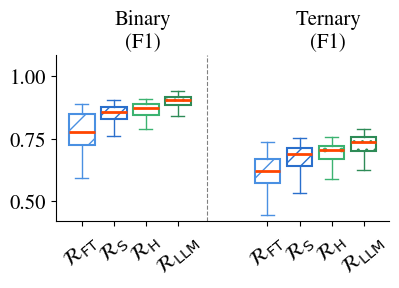

In [27]:
import matplotlib.pyplot as plt
import os

FONTSIZE = 15
CLS_TARGET = "WeightedF1Test"

data = []
labels = []

# Collect data from sources, only Binary and Ternary
sources = [bsd, tsd]
group_names = ["Binary\n(F1)", "Ternary\n(F1)"]

for source in sources:
    for feat in FEATURES:
        # Only include Binary and Ternary (assuming they correspond to first two groups)
        data.append(source[source["FeatureType"]==feat][CLS_TARGET])
        labels.append(latex_labels[feat])

# Colors and hatches per feature
feature_colors = ['#4A90E2', '#2A6FCC', '#3CB371', '#2E8B57', '#1E5F3C', '#9B59B6']
feature_hatches = ['/', '//', '.', '..', '...', 'xx']

BOX_WIDTH = 0.02
median_color = '#FF4500'
INTRA_GAP = 0.005
INTER_GAP = 0.05

# --- Compute positions ---
positions = []
group_boundaries = []
startpos = 0
n_features = len(FEATURES)

for g in range(len(group_names)):
    group_start = startpos
    for _ in range(n_features):
        positions.append(startpos)
        startpos += BOX_WIDTH + INTRA_GAP
    group_end = startpos - INTRA_GAP
    group_boundaries.append((group_start, group_end))
    startpos += INTER_GAP - INTRA_GAP

fig, ax = plt.subplots(figsize=(4,3))

# --- Plot boxes ---
for i, pos in enumerate(positions):
    arr = data[i]
    box = ax.boxplot(
        arr,
        positions=[pos],
        widths=BOX_WIDTH,
        patch_artist=True,
        showfliers=False
    )
    feature_idx = i % n_features
    color = feature_colors[feature_idx]
    hatch = feature_hatches[feature_idx]

    for patch in box['boxes']:
        patch.set(facecolor='none', hatch=hatch, edgecolor=color, linewidth=1.5)
    for whisker in box['whiskers']:
        whisker.set(color=color, linewidth=1)
    for cap in box['caps']:
        cap.set(color=color, linewidth=1)
    for median in box['medians']:
        median.set(color=median_color, linewidth=2, zorder=5)

# --- X-ticks ---
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=40, fontsize=FONTSIZE)
ax.tick_params(axis='y', labelsize=FONTSIZE)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- Vertical separators ---
for start, end in group_boundaries[:-1]:
    ax.axvline(x=end + INTRA_GAP/2, color='gray', linestyle='--', linewidth=0.8)

# --- Add group labels ---
for i, (start, end) in enumerate(group_boundaries):
    mid = (start + end) / 2
    ax.text(mid, 1.02, group_names[i], ha='center', va='bottom', fontsize=FONTSIZE, transform=ax.get_xaxis_transform())

# --- Adjust x-limits and y-limits ---
margin = 0.02
ax.set_xlim(positions[0]-margin, positions[-1]+margin)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax*1.12)

plt.tight_layout()
plt.savefig(SAVE_FOLDER + os.sep + "merged_performance.pdf", format='pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_92218/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_92218/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_92218/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_92218/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_92218/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of t

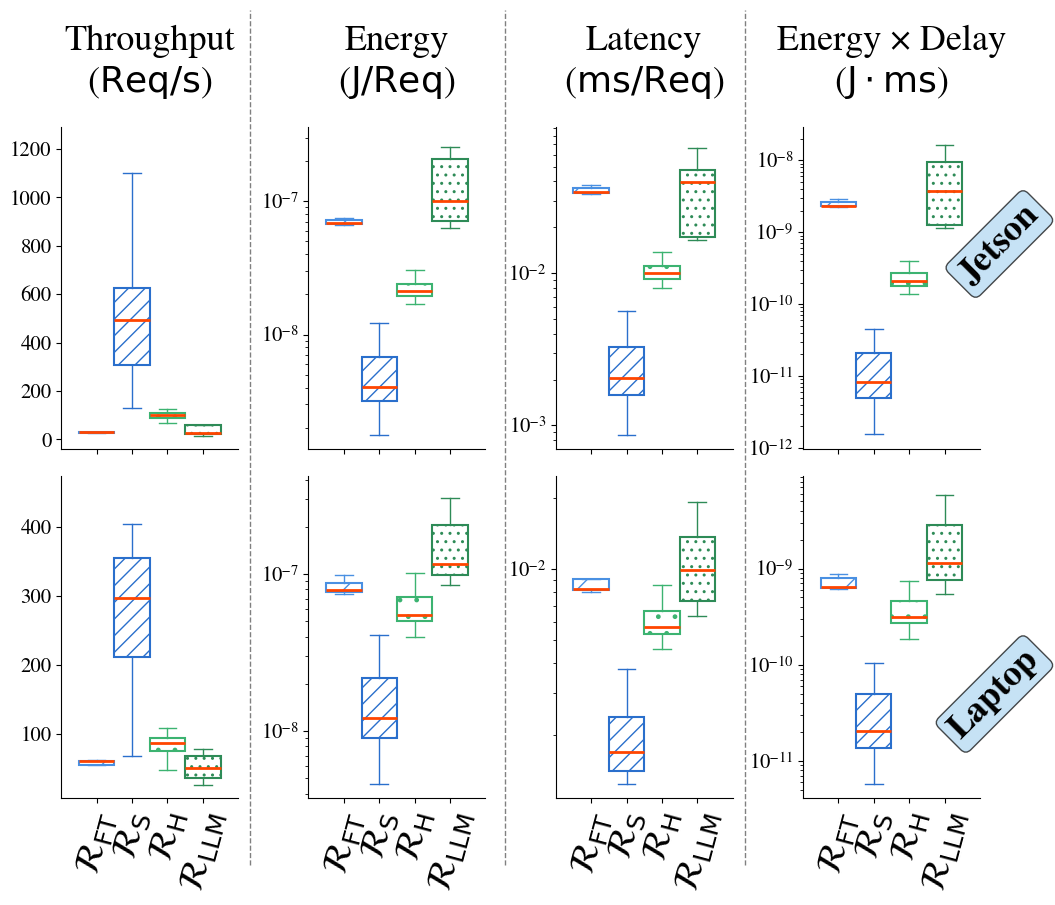

In [28]:
import matplotlib.pyplot as plt
from collections import defaultdict
import os

FONTSIZE = 26
BOX_WIDTH = 0.02
median_color = '#FF4500'
INTRA_GAP = 0.00
LABEL_BOX_COLOR = "#AED6F1"  # Light blue rectangle
LABEL_BOX_OPACITY = 0.7

metrics = [
    ("throughput", "Throughput\n($\\mathrm{Req}/\\mathrm{s}$)", False),
    ("energy_per_sample", "Energy\n($\\mathrm{J}/\\mathrm{Req}$)", True),
    ("time_per_sample", "Latency\n($\\mathrm{ms}/\\mathrm{Req}$)", True),
    ("EDP", "Energy × Delay\n($\\mathrm{J}\\cdot\\mathrm{ms}$)", True)
]

feature_colors = ['#4A90E2', '#2A6FCC', '#3CB371', '#2E8B57', '#1E5F3C', '#9B59B6']
feature_hatches = ['/', '//', '.', '..', '...', 'xx']

fig, axes = plt.subplots(2, 4, figsize=(10, 9), sharex=True)
fig.subplots_adjust(wspace=0.4, hspace=0.5)  # spacing between subplots

def plot_row(ax_row, sources):
    for ax, (CLS_TARGET, ylabel, logscale) in zip(ax_row, metrics):
        data = defaultdict(list)
        for source in sources:
            for feat in FEATURES:
                dt = source[source["FeatureType"] == feat][CLS_TARGET]
                data[feat].extend(dt)

        labels = [latex_labels[t] for t in data.keys()]
        data_list = list(data.values())

        positions = []
        startpos = 0
        for _ in range(len(FEATURES)):
            positions.append(startpos)
            startpos += BOX_WIDTH + INTRA_GAP

        for i, pos in enumerate(positions):
            arr = data_list[i]
            box = ax.boxplot(
                arr,
                positions=[pos],
                widths=BOX_WIDTH,
                patch_artist=True,
                showfliers=False
            )

            feature_idx = i % len(FEATURES)
            color = feature_colors[feature_idx]
            hatch = feature_hatches[feature_idx]

            for patch in box['boxes']:
                patch.set(facecolor='none', hatch=hatch, edgecolor=color, linewidth=1.5)
            for whisker in box['whiskers']:
                whisker.set(color=color, linewidth=1)
            for cap in box['caps']:
                cap.set(color=color, linewidth=1)
            for median in box['medians']:
                median.set(color=median_color, linewidth=2, zorder=5)

        if logscale:
            ax.set_yscale('log')

        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=75, fontsize=FONTSIZE)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax * 1.12)
        margin = 0.02
        ax.set_xlim(positions[0] - margin, positions[-1] + margin)

# Plot first row: Jetson
plot_row(axes[0], [jsd])
# Plot second row: Laptop
plot_row(axes[1], [lsd])

# Add metric names as column headers on top row
for col in range(4):
    axes[0, col].set_title(metrics[col][1], fontsize=FONTSIZE, pad=25)  # pad moves it above plots

# Add vertical dashed lines between columns
from matplotlib.lines import Line2D

# Example tunable coordinates
# You can adjust these numbers between 0 and 1 to move lines
x_fracs = [0.255, 0.51, 0.75]   # x positions between columns
y_bottom_frac = 0.05            # bottom of dashed line
y_top_frac = 1               # top of dashed line

for x0 in x_fracs:
    line = Line2D([x0, x0], [y_bottom_frac, y_top_frac], transform=fig.transFigure,
                  color='gray', linestyle='--', linewidth=1)
    fig.add_artist(line)
# Text for each row
row_texts_left = ["Jetson", "Laptop"]   # left side

# Adjust the y positions for each row (0 = bottom, 1 = top)
y_positions = [0.78, 0.28]  # approximate vertical center of each row

for i, y in enumerate(y_positions):
    # Left side text
    # fig.text(-0.01, y, row_texts_left[i], fontsize=FONTSIZE, va='center', ha='left', fontweight='bold', rotation=90)
    # Right side text
    fig.text(1.05, y-0.04, row_texts_left[i], fontsize=FONTSIZE, va='center', ha='right', fontweight='bold', rotation=45,bbox=dict(facecolor=LABEL_BOX_COLOR, alpha=LABEL_BOX_OPACITY, edgecolor='black', boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.savefig(SAVE_FOLDER + os.sep + "merged_efficiency_boxplots.pdf",
            format='pdf', bbox_inches='tight')
plt.show()


In [26]:
import pandas as pd
import numpy as np

# ---------------------------
# Config
# ---------------------------
DEVICES = {
    "Jetson": jsd,
    "Laptop": lsd
}
TASK_CLASS = None
BASELINE = "fasttext"
METRICS = ["time_per_sample", "energy_per_sample", "EDP", "throughput"]

# ---------------------------
# Compute relative metrics per device
# ---------------------------
def compute_relative_metrics(df, baseline=BASELINE, n_class=None):
    relative = {}
    for m in FEATURES:
        mask = df["FeatureType"] == m
        if n_class is not None:
            mask &= df["N_class"] == n_class
        
        median_latency = df.loc[mask, "time_per_sample"].median()
        median_energy  = df.loc[mask, "energy_per_sample"].median()
        median_edp     = df.loc[mask, "EDP"].median()
        median_throughput = df.loc[mask, "throughput"].median()
        
        relative[m] = {
            "latency": median_latency,
            "energy": median_energy,
            "EDP": median_edp,
            "throughput": median_throughput
        }
    
    # Normalize vs baseline
    baseline_vals = relative[baseline]
    for m in FEATURES:
        relative[m]["speedup_latency"] = baseline_vals["latency"] / relative[m]["latency"]
        relative[m]["energy_reduction"] = baseline_vals["energy"] / relative[m]["energy"]
        relative[m]["EDP_reduction"] = baseline_vals["EDP"] / relative[m]["EDP"]
        relative[m]["throughput_gain"] = relative[m]["throughput"] / baseline_vals["throughput"]
    
    return relative

# ---------------------------
# Build merged table with subcolumns for devices
# ---------------------------
rows = []
for method in FEATURES:
    row = {"Method": method}
    for device_name, df in DEVICES.items():
        rel = compute_relative_metrics(df, baseline=BASELINE, n_class=TASK_CLASS)
        row[f"Latency Speedup ({device_name} ×)"] = rel[method]["speedup_latency"]
        row[f"Throughput Gain ({device_name} ×)"] = rel[method]["throughput_gain"]
        row[f"Energy Reduction ({device_name} ×)"] = rel[method]["energy_reduction"]
        row[f"EDP Reduction ({device_name} ×)"] = rel[method]["EDP_reduction"]
    rows.append(row)

rel_table = pd.DataFrame(rows)
rel_table = rel_table.round(2)
rel_table

,Method,Latency Speedup (Jetson ×),Throughput Gain (Jetson ×),Energy Reduction (Jetson ×),EDP Reduction (Jetson ×),Latency Speedup (Laptop ×),Throughput Gain (Laptop ×),Energy Reduction (Laptop ×),EDP Reduction (Laptop ×)
0,fasttext,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,we,16.79,16.79,16.96,287.25,4.90,4.90,6.49,31.82
2,wefe,3.41,3.41,3.25,11.03,1.44,1.44,1.43,2.05
3,fe,0.86,0.86,0.68,0.63,0.83,0.83,0.68,0.57
